In [ ]:
!pip install transformers datasets sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.3 MB/s eta 0:00:00


In [ ]:
# load data
from datasets import load_dataset
data = load_dataset('kde4', lang1="en", lang2="fr")
data

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.10k [00:00<?, ?B/s]

kde4.py:   0%|          | 0.00/4.25k [00:00<?, ?B/s]

The repository for kde4 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/kde4.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/210173 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

In [ ]:
new_data = data["train"].shuffle(seed=42).select(range(210173//2)) # using 50% of data
split = new_data.train_test_split(seed=42)

In [ ]:
split

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 78814
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 26272
    })
})

In [ ]:
split["train"][0]

{'id': '184719',
 'translation': {'en': 'This location is already defined. Do you want to replace the existing one?',
  'fr': 'Cet emplacement est déjà défini. Voulez -vous remplacer celui qui était défini précédemment & #160;?'}}

In [ ]:
from transformers import AutoTokenizer
checkpoint = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
en=split["train"][10]["translation"]["en"]
fr=split["train"][10]["translation"]["fr"]
en, fr

('Error in opening output file', "Erreur d'ouverture du fichier de sortie")

In [ ]:
inputs = tokenizer(en)
inputs

{'input_ids': [26088, 18, 4295, 8033, 1437, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [ ]:
# tokenize target sentence
with tokenizer.as_target_tokenizer():
  targets = tokenizer(fr)

targets


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [34023, 20, 6, 4261, 22, 2428, 5, 5607, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.convert_ids_to_tokens(targets["input_ids"])

['▁Erreur',
 '▁d',
 "'",
 'ouverture',
 '▁du',
 '▁fichier',
 '▁de',
 '▁sortie',
 '</s>']

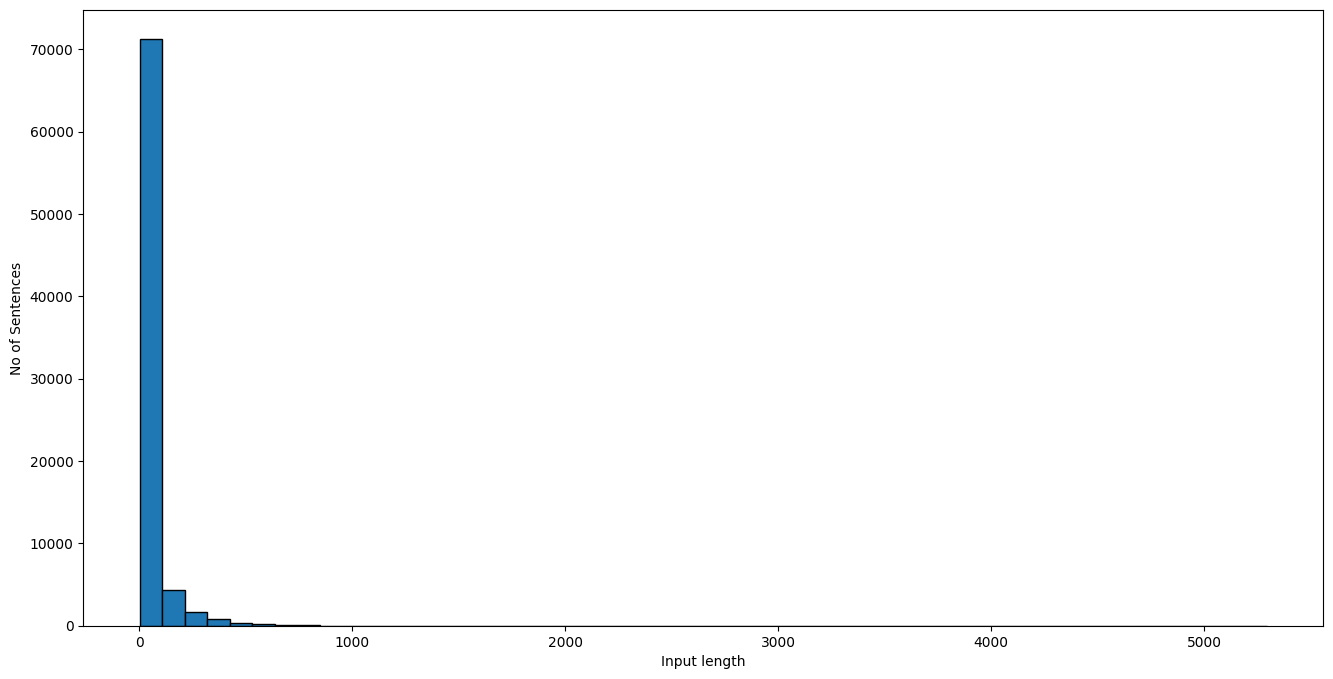

In [ ]:
import matplotlib.pyplot as plt
train = split["train"]["translation"]
input_lens = [len(tr["en"]) for tr  in train]

plt.figure(figsize=(16,8))
plt.hist(input_lens, bins=50, edgecolor="black")
plt.xlabel("Input length")
plt.ylabel("No of Sentences")
plt.show()


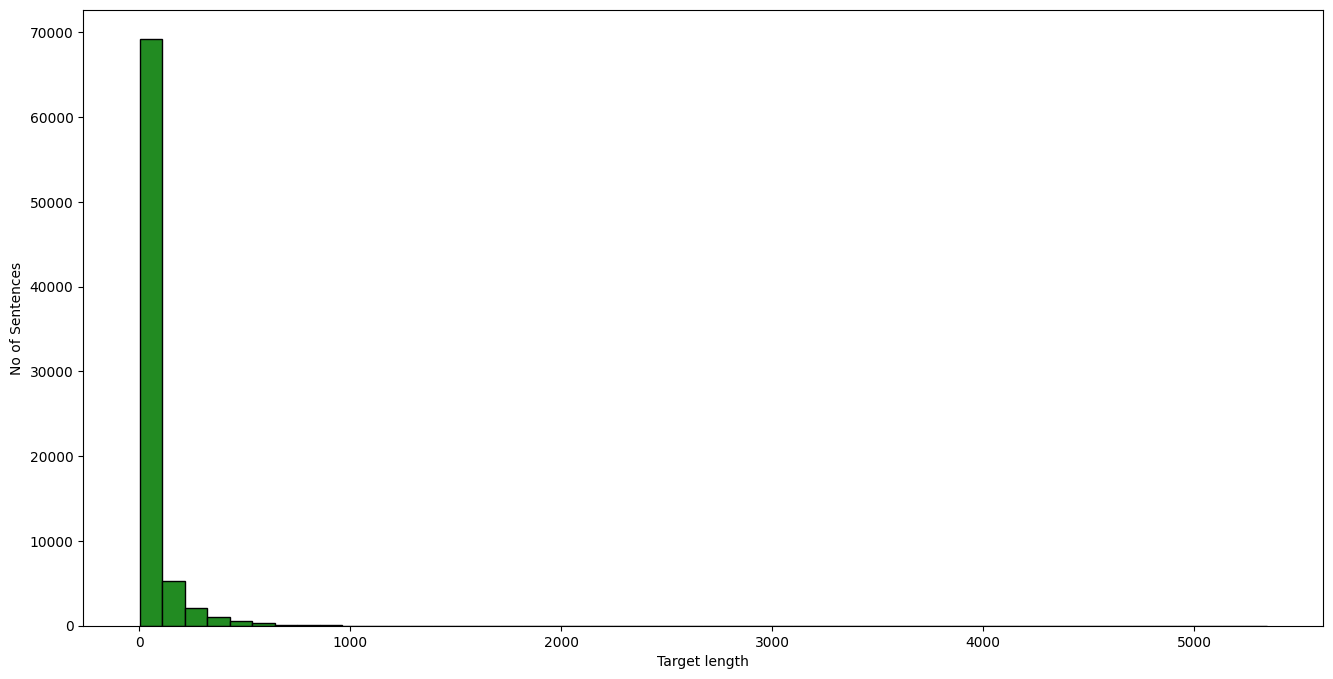

In [ ]:
target_lens = [len(te["fr"]) for te in train]

plt.figure(figsize=(16,8))
plt.hist(target_lens, bins=50, edgecolor="black", color="forestgreen")
plt.xlabel("Target length")
plt.ylabel("No of Sentences")
plt.show()


In [ ]:
# create tokenizer function
max_input_len = 256
max_target_len = 256

def tokenizer_fn(batch):
  inputs= [x["en"] for x in batch["translation"]]
  targets= [x["fr"] for x in batch["translation"]]

  tokenized_inputs= tokenizer(
      inputs,
      max_length = max_input_len,
      truncation = True
  )
  with tokenizer.as_target_tokenizer():
    tokenized_targets= tokenizer(
        targets,
        max_length = max_target_len,
        truncation = True
    )

    tokenized_inputs["labels"] = tokenized_targets["input_ids"]

    return tokenized_inputs


In [ ]:
# storing tokenized data
tokenized_datasets = split.map(
    tokenizer_fn,
    batched = True,
    remove_columns = split["train"].column_names,

)

Map:   0%|          | 0/78814 [00:00<?, ? examples/s]

Map:   0%|          | 0/26272 [00:00<?, ? examples/s]

In [ ]:
# view tokenized dataset
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 78814
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 26272
    })
})

In [ ]:
# creating seq2seq transformer model
from transformers import AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [ ]:
# using datacollator for padding and converting into torch tensor
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


In [ ]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1,3)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [ ]:
batch['labels']

tensor([[33261,    16,  2316, 21258,  1817,     9,     0,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100],
        [15479,    16,  3521,    17,   370,     5,     8,   421,     5,   372,
         12647,  1071,   634,  1150,   137,     6,    82,  6941,  9177,     9,
             9,  1819,     0]])

In [ ]:
print(type(batch["labels"]))

<class 'torch.Tensor'>


In [ ]:
batch["decoder_input_ids"]

tensor([[59513, 33261,    16,  2316, 21258,  1817,     9,     0, 59513, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513],
        [59513, 15479,    16,  3521,    17,   370,     5,     8,   421,     5,
           372, 12647,  1071,   634,  1150,   137,     6,    82,  6941,  9177,
             9,     9,  1819]])

In [ ]:
print(type(batch["decoder_input_ids"]))

<class 'torch.Tensor'>


In [ ]:
tokenizer.convert_ids_to_tokens(batch["decoder_input_ids"][0])

['<pad>',
 '▁Affiche',
 '▁les',
 '▁structures',
 '▁cristal',
 'line',
 's',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [ ]:
tokenizer.convert_ids_to_tokens(batch["labels"][0])


['▁Affiche',
 '▁les',
 '▁structures',
 '▁cristal',
 'line',
 's',
 '</s>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>']

In [ ]:
split["train"][1]

{'id': '21914',
 'translation': {'en': 'Weight', 'fr': 'Affiche les structures cristallines'}}

In [ ]:
!pip install sacrebleu bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.6 MB/s eta 0:00:00


In [ ]:
import evaluate
bleu_metric = evaluate.load("sacrebleu")
bert_metric = evaluate.load("bertscore")

In [ ]:
bleu_metric.compute(predictions=["I love cats."], references=[["I love cats."]])

{'score': 100.00000000000004,
 'counts': [4, 3, 2, 1],
 'totals': [4, 3, 2, 1],
 'precisions': [100.0, 100.0, 100.0, 100.0],
 'bp': 1.0,
 'sys_len': 4,
 'ref_len': 4}

In [ ]:
from transformers.models import reformer
s = "Unreal Engine is a 3D computer graphics game engine developed by Epic Games, first showcased in the 1998 first-person shooter game Unreal."
bleu_metric.compute(predictions=[s], references=[[s]])

{'score': 100.00000000000004,
 'counts': [24, 23, 22, 21],
 'totals': [24, 23, 22, 21],
 'precisions': [100.0, 100.0, 100.0, 100.0],
 'bp': 1.0,
 'sys_len': 24,
 'ref_len': 24}

In [ ]:
bert_metric.compute(
    predictions=["I love cats."],
    references=[["I like cats."]],
    lang="en"
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.9877963662147522],
 'recall': [0.9877963662147522],
 'f1': [0.9877963662147522],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.48.3)'}

In [ ]:
# using blue metric there is no similarity for words
bleu_metric.compute(
    predictions=["I love cats."],
    references=[["I like cats."]]
)

{'score': 35.35533905932737,
 'counts': [3, 1, 0, 0],
 'totals': [4, 3, 2, 1],
 'precisions': [75.0, 33.333333333333336, 25.0, 25.0],
 'bp': 1.0,
 'sys_len': 4,
 'ref_len': 4}

In [ ]:
# create personal compute_metric function

import numpy as np

def compute_metrics(preds_and_labels):
  preds, labels = preds_and_labels

  #convert preds into words
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  labels = np.where(labels!= -100, labels, tokenizer.pad_token_id)
  decoded_labels= tokenizer.batch_decode(labels, skip_special_tokens=True)

  decoded_preds = [pred.strip() for pred in decoded_preds]
  decoded_labels= [[label.strip()] for label in decoded_labels]

  bleu= bleu_metric.compute(
      predictions= decoded_preds,
      references= decoded_labels
  )
  bert_score= bert_metric.compute(
      predictions= decoded_preds,
      references= decoded_labels,
      lang="fr"
  )

  return {"bleu": bleu["score"], "bert_score": np.mean(bert_score["f1"])}


In [ ]:
# creating training arguments
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    "finetuned-model",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True, # makes it autoregressive
    fp16=True,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# trainer
from transformers import Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["test"],
    data_collator = data_collator,
    processing_class = tokenizer,
    compute_metrics = compute_metrics,
)

In [ ]:
#checking metrics before begining
trainer.evaluate(max_length=max_target_len)

In [ ]:
# higher gpu or restart runtime
trainer.train()

In [ ]:
#checking metrics again
trainer.evaluate(max_length=max_target_len)

In [ ]:
trainer.save_model("my_saved_model")

In [ ]:
from transformers import pipeline
translator = pipeline("translation", model = "my_saved_model", device=0)

In [ ]:
translator("I hope you are doing well.")

In [ ]:
translator("Hello How are you doing today?, let's learn Deep Learning")

In [ ]:
translator("Work until you achieve your goal.")